# Markov State Modelling: Time Dependent Dimensional Reduction

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy
from scipy.linalg import eig
from matplotlib.lines import Line2D
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from statsmodels.graphics.tsaplots import plot_acf

In [34]:
dataReal = np.loadtxt("airT_dec5.txt",skiprows=0,unpack=True).T

In [35]:
print(np.shape(dataReal))

(21578, 96)


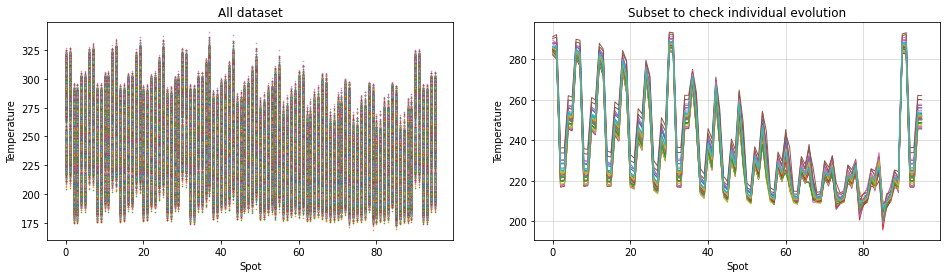

In [36]:
fig = plt.figure()
fig.set_size_inches(16,4)

ax =plt.subplot2grid((1,2), (0,0))
plt.ylabel('Temperature')
plt.xlabel('Spot')
plt.title('All dataset')
for i in range(len(dataReal)):
    plt.plot(dataReal[i],'o',markersize = 0.5)
    
ax =plt.subplot2grid((1,2), (0,1))
plt.ylabel('Temperature')
plt.xlabel('Spot')
plt.title('Subset to check individual evolution')
for i in range(10,40):
    plt.plot(dataReal[i],linewidth=1)
plt.grid(alpha=0.5)

plt.show()

In [37]:
mean = np.mean(dataReal,axis=0)
std = np.std(dataReal,axis=0)
data = (dataReal - mean)/std

In [38]:
def PCA(data):
    cov = np.cov(data.T)
    eig, vecs = np.linalg.eig(cov)
    idx = eig.argsort()[::-1]   
    eig = eig[idx]
    vecs = vecs[:,idx]
    vecs = vecs.T

    return vecs, eig

In [39]:
vecs, eigs = PCA(data)

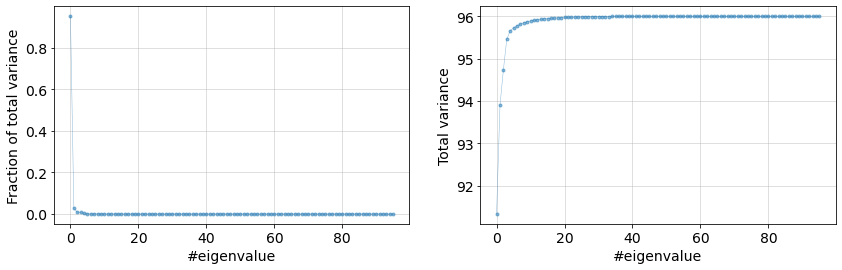

In [40]:
totvar = np.sum(eigs)
normeig = eigs/totvar

cums = np.zeros(len(eigs))
cums[0] = eigs[0]
for i in range(len(eigs)):
    cums[i] = cums[i - 1] + eigs[i]

fig = plt.figure()
fig.set_size_inches(14,4)

ax =plt.subplot2grid((1,2), (0,0))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("#eigenvalue",fontsize=14)
plt.ylabel("Fraction of total variance",fontsize=14)
plt.plot(range(0,len(data[0]),1),normeig,'o-',markersize=3,alpha=0.5,lw=0.5)
plt.grid(alpha=0.5)

ax =plt.subplot2grid((1,2), (0,1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(cums,'o-',markersize=3,alpha=0.5,lw=0.5)
plt.xlabel('#eigenvalue',fontsize=14)
plt.ylabel('Total variance',fontsize=14)
plt.grid(alpha=0.5)

plt.show()

In [41]:
pcdata = vecs[:2]@data.T

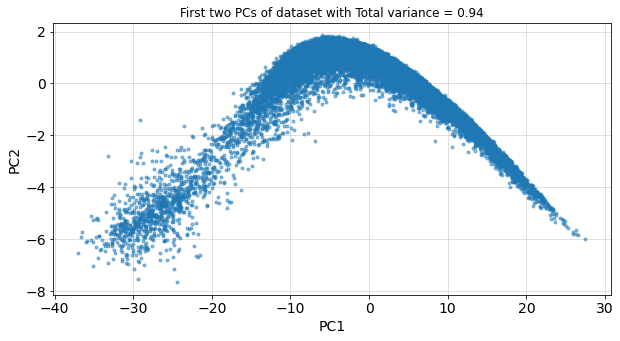

In [42]:
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("PC1",fontsize=14)
plt.ylabel("PC2",fontsize=14)
plt.plot(pcdata[0],pcdata[1],'o',markersize=3,alpha=0.5)
plt.grid(alpha=0.5)
plt.title('First two PCs of dataset with Total variance = 0.94')
plt.show()

In [43]:
def plotAutocorrelation(data):
    plot_acf(data,lags=500)
    plt.grid(alpha=0.5)
    plt.xlabel('time')
    plt.ylabel('autocorrelation')

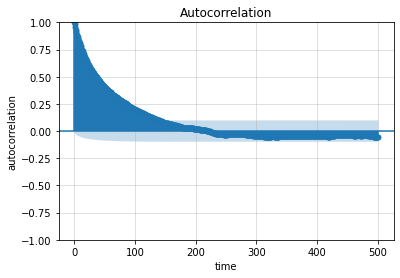

In [44]:
plot_acf(dataReal[:,42],lags=500)
plt.grid(alpha=0.5)
plt.xlabel('time')
plt.ylabel('autocorrelation')

plt.show()

In [45]:
def dist(data, centers, exponent = 2):
    distance = np.sum((np.array(centers) - data[:,None])**(exponent), axis = 2)
    return distance

def chooseCluster(centers,x):
    dists = dist(centers,np.array([x]))
    dists = np.sqrt(dists)
    minimum = np.min(dists)
    minima = np.where(dists == minimum)
    return minima[0], minimum

def estimateCentroids(labs,x,k):
    ncomp = np.zeros(k)
    newc = np.zeros((k,len(x[0])))
                     
    for i in range(len(x)):
        for j in range(len(x[0])):
            newc[labs[i],j] += x[i,j]
        ncomp[labs[i]] += 1
    for i in range(len(x[0])):
        for j in range(k):
            newc[j,i] = newc[j,i]/ncomp[j]
    return newc

def kplusplus(k, X):
    centers = []
    X = np.array(X)
    idx = np.random.choice(range(len(X)))
    centers.append(X[idx, :].tolist())
     
    for i in range(k - 1):
        distance = dist(X, np.array(centers))
        if i == 0:
            pdf = distance/np.sum(distance)
            newc = X[np.random.choice(range(len(X)), replace = False, p = pdf.flatten())]
        else:
            dist_min = np.min(distance, axis = 1)
            pdf = dist_min/np.sum(dist_min)
            newc = X[np.random.choice(range(len(X)), replace = False, p = pdf)]

        centers.append(newc.tolist())
        
    return np.array(centers)
                            
def kmeans(data,k,niter):
    cs = kplusplus(k,data)
    labels = np.zeros(len(data),dtype = int)
    objfunc = []
    for j in range(niter):
        objfunc.append(0)
        labtemp = +labels
        for i in range(len(data)):
            labels[i], minimum = chooseCluster(cs,data[i])
            objfunc[j] += minimum**2
        cs = estimateCentroids(labels,data,k)
        if ((labtemp == labels).all()):
            break
    return labels,objfunc,cs

In [46]:
def createPlot(data,labels,centroids,k,two = True):
    #fig = plt.gcf()
    #fig.set_size_inches(10,5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("x",fontsize=14)
    plt.ylabel("y",fontsize=14)
    colors = ['Coral','CornFlowerBlue']
    plt.scatter(data[0],data[1], c=labels, cmap=matplotlib.colors.ListedColormap(colors),alpha = 0.4)
    plt.scatter(centroids[:,0],centroids[:,1],marker='X',c='red')
    plt.title('k = %s' %k)

    plt.grid()
    plt.show()

In [49]:
labelprova, objprova, centersprova = kmeans(pcdata.T,k=30,niter=100) 
Piprova = generatePi(40, labelprova, 30)

In [50]:
centersmegaprova,labelmegaprova = orderClusters(centersprova,labelprova)
Pimegaprova = generatePi(40,labelmegaprova,30)

/home/ivang/.local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


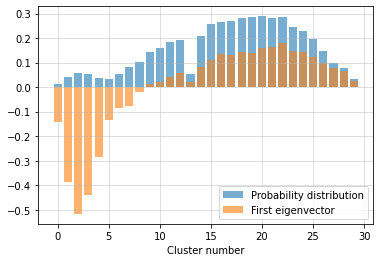

In [53]:
probDist = +Pivecsprova[0]/np.sum(Pivecsprova[0])
plt.bar(range(0,len(probDist)),Pivecsprova[0],alpha=0.6,label='Probability distribution')
plt.bar(range(0,len(probDist)),Pivecsprova[1],alpha=0.6,label='First eigenvector')
plt.grid(alpha=0.5)
plt.xlabel('Cluster number')
plt.legend()

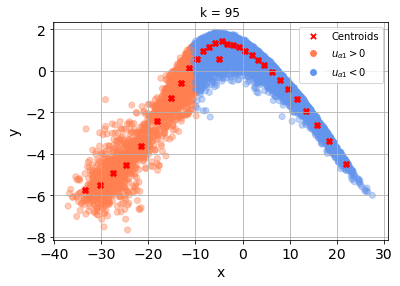

In [52]:
tausprova,Pivecsprova,cfs = getTaus(40,Pimegaprova)
statesprova = createMarkovStates(Pivecsprova,pcdata,labelmegaprova, i, centersmegaprova,cfs,plots=True)

In [54]:
a = np.array([[2,4,9],[4,4,12],[3,3,15]])
b = np.array([1,2,3])
print(a/b.T)

[[2.  2.  3. ]
 [4.  2.  4. ]
 [3.  1.5 5. ]]


In [55]:
def generatePi(tau,labels,k):
    Pitest = np.zeros((k,k))
    fractions = np.zeros(k)
    for i in range(len(labels) - tau):
        Pitest[labels[i],labels[i + tau]] += 1
        fractions[labels[i]] += 1
    fractions[fractions == 0] = 1
    Pitest /= fractions
    return Pitest

def orderClusters(centers,labels):
    idx = centers[:,0].argsort()
    labels = np.array(labels)
    newCenters = centers[idx]
    newLabels = np.zeros(len(labels),dtype=int)
    for i in range(len(labels)):
        newLabels[i] = int(np.where(idx == labels[i])[0])
    return newCenters, newLabels
    
def getTaus(tau,Pi,plots=False):
    Pieig, Pileft, Piright = eig(Pi,left = True)
    Piidx = np.abs(Pieig).argsort()[::-1]   
    Pieig = Pieig[Piidx]
    Pileft = Pileft[:,Piidx]
    Piright = Piright[:,Piidx]
    if(Piright[0,0] < 0):
        Piright = -Piright
        Pileft = -Pileft
    Piright = Piright.T
    Pileft = Pileft.T
    coef = np.sum(Pileft[1])
    taus = - tau/np.log(np.abs(Pieig[1:]))
    
    if(plots):
        ig,ax = plt.subplots()
        plt.xlabel('$\gamma$',fontsize = 14)
        plt.xticks(range(1,len(Pi),int(len(Pi)/10)))
        ax.set_ylabel(r'$\tau^{\gamma}$',color='C1',fontsize=14)
        ax.plot(range(1,len(taus) + 1),taus,'o-',color='C1',markersize = 5,lw=1, alpha = 0.5)
        ax.tick_params(axis='y', colors='C1')
        
        ax2=ax.twinx()
        ax2.tick_params(axis='y', colors='C2')
        ax2.set_ylabel("eigenvalues",color='C2',fontsize=14)
        ax2.plot(range(1,len(taus) + 1),np.abs(Pieig[1:]),'o-',color='C2',markersize = 5,lw=1, alpha = 0.5,label = 'eigenvalues')

        plt.title(r'$\tau$ = %s' %tau + ' k = %s' %k)
        ax.grid(alpha=0.3)
        plt.show()
        
    return taus,Piright,coef

def tauplot(testtaus,tau1s,k):
    plt.plot(testtaus,tau1s,'o-',markersize=2,alpha=0.5)
    plt.xscale('log')
    plt.grid(alpha=0.5)
    plt.xlabel(r'$\tau$',fontsize=14)
    plt.ylabel(r'$\tau^1$',fontsize=14)
    plt.title('k=%s' %k)
    plt.show()
    
def createMarkovStates(Pivecs,pcdata,labels,k,centroids,coef,plots = False):
    twoclustermarkovstates = np.zeros(len(Pivecs[1]))
    for i in range(len(Pivecs[1])):
        twoclustermarkovstates[i] = 0 if Pivecs[1,i]*coef > 0 else 1   
    if(plots):
        legend_elements = [ Line2D([0], [0], marker='X', color='w', label='Centroids',
                               markerfacecolor='r', markersize=8),
                        Line2D([1], [0], marker='o', color='w', label=r'$u_{\alpha1} > 0$',
                               markerfacecolor='Coral', markersize=8),
                        Line2D([2], [0], marker='o', color='w', label=r'$u_{\alpha1} < 0$',
                               markerfacecolor='CornFlowerBlue', markersize=8)]
        plt.legend(handles=legend_elements)
        createPlot(pcdata,twoclustermarkovstates[labels],centroids,k)
        
    return twoclustermarkovstates[labels]

In [56]:
testtaus = (1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150,160,170,180,190,200,300,400,500,1000)
testks = (2,5,10,20,30,40,50,60,70,80,90,100,150,200,300,500,1000)
totalTau1s = []
totalCenters = []
totalLabels = []

for i in testks:
    labelstest, objtest, centroidstest = kmeans(pcdata.T,k=i,niter=100)
    totalCenters.append(centroidstest)
    totalLabels.append(labelstest)
    
    tau1s = []
    for tau in testtaus:
        Pitest = generatePi(tau, labelstest, i)
        taustest,Pivecstest = getTaus(tau,Pitest)
        states = createMarkovStates(Pivecstest,pcdata,labelstest, i, centroidstest)
        tau1s.append(taustest[0])
    #tauplot(testtaus,tau1s,i)
    totalTau1s.append(tau1s)
    

ValueError: too many values to unpack (expected 2)

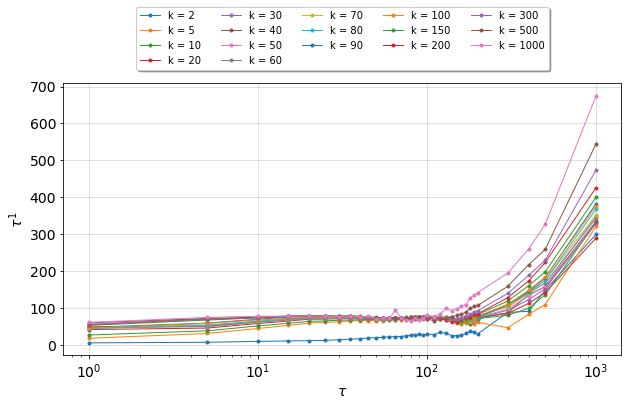

In [274]:
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
    
for i in range(len(testks)):
    plt.plot(testtaus,totalTau1s[i],'o-',markersize=3,lw='1',label= 'k = %s' %testks[i])

plt.xscale('log')
plt.xlabel(r'$\tau$',fontsize=14)
plt.ylabel(r'$\tau^1$',fontsize=14)
plt.grid(alpha = 0.5)    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=5, fancybox=True, shadow=True)  
plt.show()

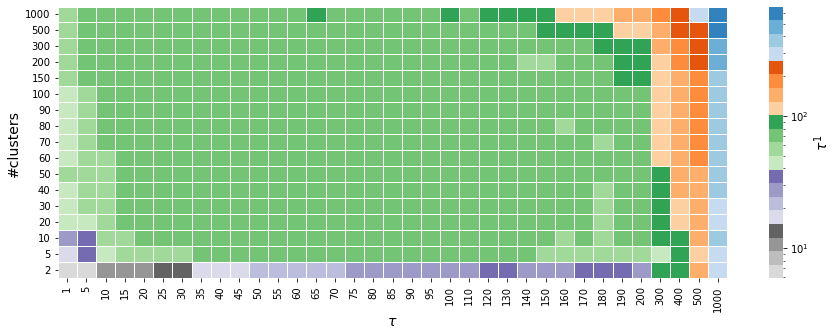

In [275]:
plt.figure(figsize = (15,5))
hm = sns.heatmap(totalTau1s[::-1],xticklabels = testtaus, yticklabels = testks[::-1],norm=LogNorm(),linewidth=0.5,cmap='tab20c_r')
plt.ylabel('#clusters',fontsize=14)
plt.xlabel(r'$\tau$',fontsize=14)
hm.collections[0].colorbar.set_label(r'$\tau^1$',fontsize=14)
plt.show()

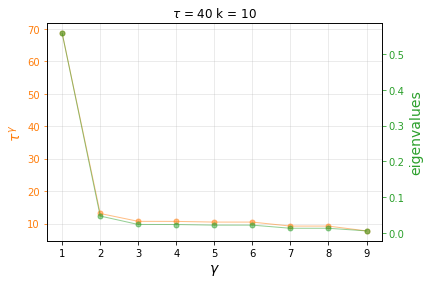

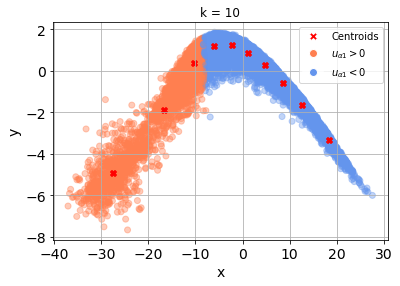

(-0.8520857211468463+0j)


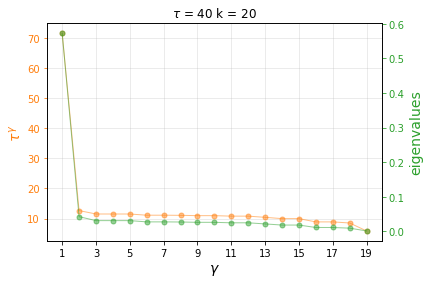

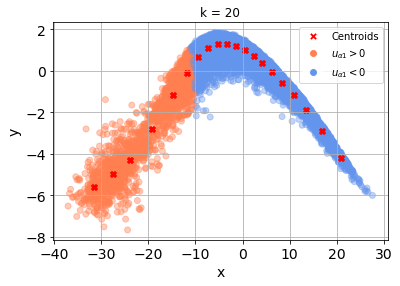

(-1.5942723943554917+0j)


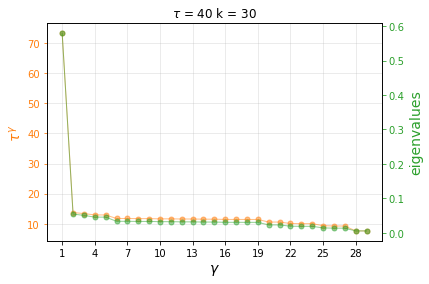

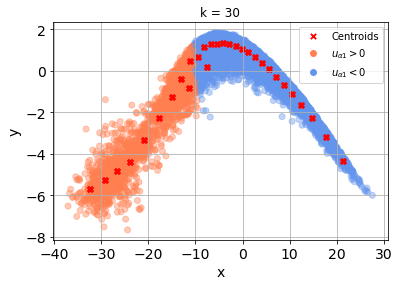

(-2.062032156631858+0j)


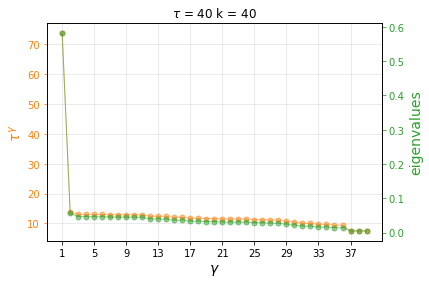

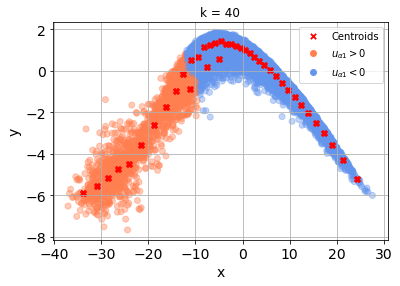

(-2.2163384671567865+0j)


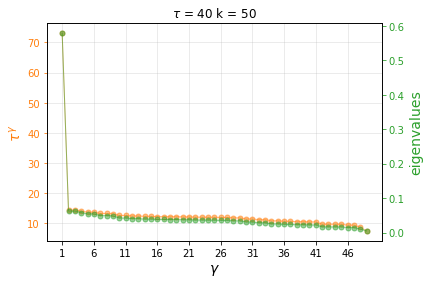

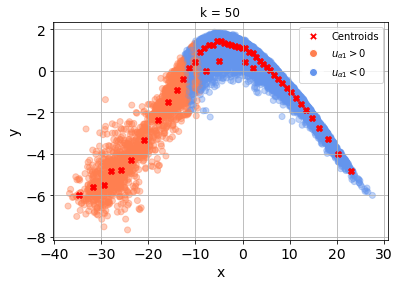

(2.208494939072367+0j)


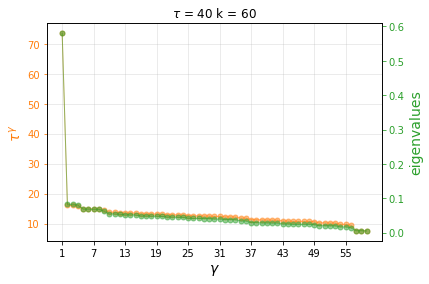

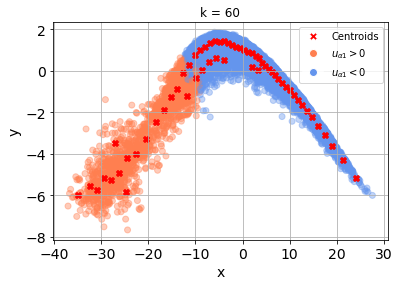

(3.044666446484845+0j)


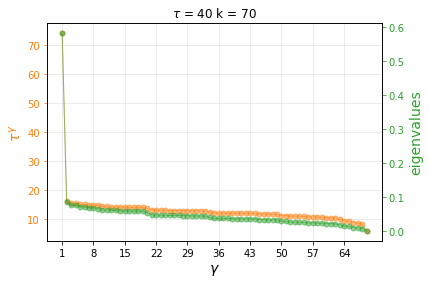

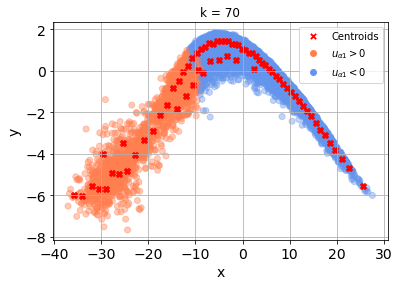

(3.26998505611095+0j)


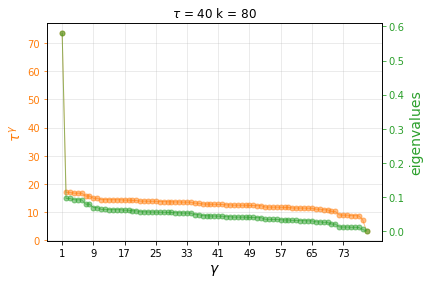

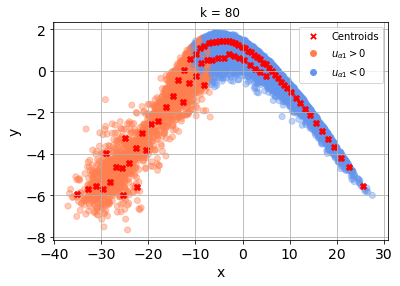

(3.603276677896316+0j)


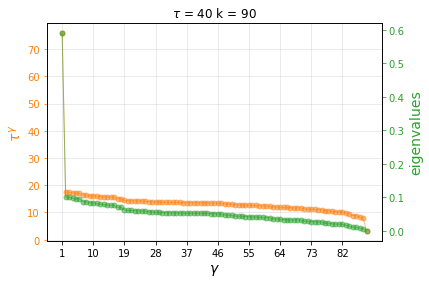

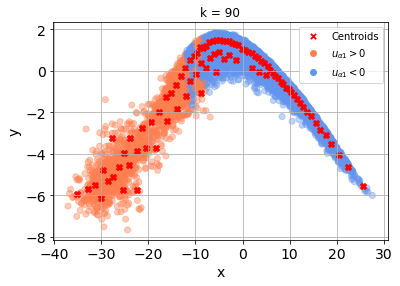

(4.016398808417737+0j)


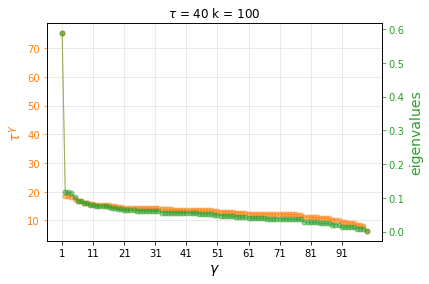

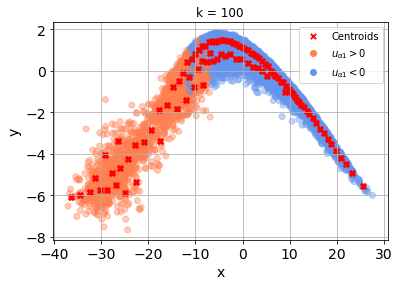

(3.7304893082248296+0j)


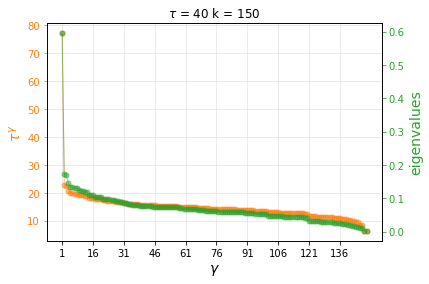

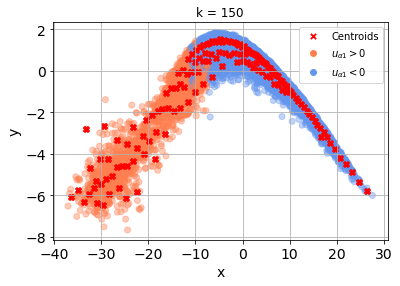

(-5.325460670428657+0j)


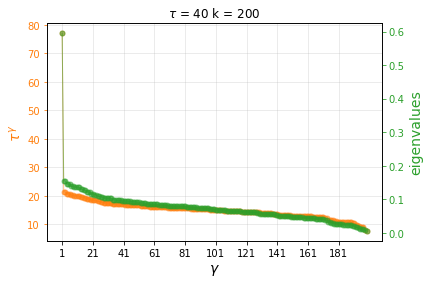

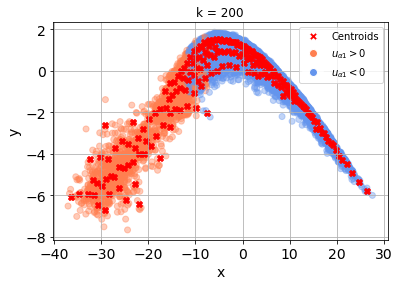

(5.85209927744328+0j)


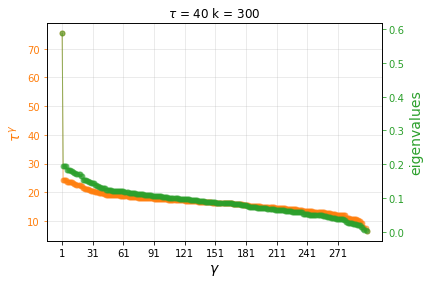

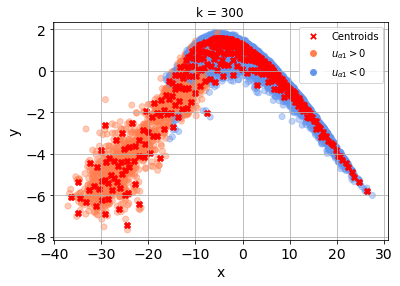

(-7.151629681977145+0j)


In [337]:
tau = 40
i = 2
for k in testks[2:-2]:
    labs = totalLabels[i]
    Pi = generatePi(tau, labs, k)
    taus,Pivecs,coefs= getTaus(tau,Pi,plots = True)
    markovstates = createMarkovStates(Pivecs,pcdata,labs, k, totalCenters[i],coefs,plots = True)
    print(coefs)
    i += 1
    
plt.show()

In [159]:
testks[2:-1]

(10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 300, 500)

In [ ]:
dataTrain,dataTest,labTrain,labTest=train_test_split(pcdata.T,markovstates,test_size=0.25,random_state=0)

In [ ]:
print(dataTrain.shape,dataTest.shape,labTrain.shape,labTest.shape)

In [ ]:
def multiRegression(learn_labs,test_labs,pcL,pcT):
    pred_labs = np.zeros((ncomp,len(test_labs)),dtype = int)
    mutinfo = np.zeros(ncomp)
    for i in range(1,ncomp+1):
        mlr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(pcL[:,:i], learn_labs)
        pred_labs[i-1] = mlr.predict(pcT[:,:i])
        mutinfo[i-1] = metrics.mutual_info_score(test_labs, pred_labs[i-1])
    return pred_labs, mutinfo

In [ ]:
ncomp = 2
pred_labs, mutinfo = multiRegression(labTrain,labTest,dataTrain,dataTest)

In [ ]:
col = ['red','blue']
plt.scatter(dataTest[:,0],dataTest[:,1], c=labTest, cmap='viridis')
plt.show()

plt.scatter(dataTest[:,0],dataTest[:,1], c=pred_labs[1], cmap='viridis',alpha=0.4,s=1)
plt.show()

In [ ]:
correct = np.zeros((4,ncomp),dtype = int)
for j in range(ncomp):
    for i in range(4):
        correct[i,j] = np.count_nonzero(pred_labs[j,pred_labs[j,:] == i] == test_labs[pred_labs[j,:] == i])
frac_correct = np.sum(correct,axis=0)/1000

plt.plot(mutinfo,'o')